### Introduction

It's easy to ask what the distance between two points is, but what is the distance between two lines? Of course, this will depend on what we mean by distance in this case. So, more precisely, what's the smallest distance between any point on one line and a point on the other? Moreover, how do we find these closest points?

Of course, if the lines intersect, the smallest distance is 0, and the closest points are both at the intersection point. Similarly, if the lines are parallel, there are no "closest points", as for every pair of points a distance $d$ away from eachother, there exists another pair of points, also a distance $d$ from eachother, which can be found by translating our first pair along the direction of the lines.

Why might we care? Well, if curiosity over how to solve such a seemingly simple problem is not enough, there are a few uses. In game physics, it is common to simulate "capsules", which are pill like shapes defined by two points and a radius. The capsule is all points within a radius-length of the two points or the line segment connecting them:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

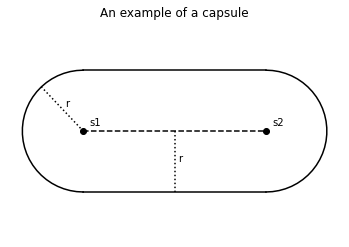

In [2]:
s1 = np.array([2.0, 2.0])
s2 = np.array([5.0, 2.0])

r = 1.0

points = 30

theta = np.linspace(-np.pi/2, np.pi/2, points)
circle = lambda c, r, th: np.array([c[0] + r*np.cos(th), c[1] + r*np.sin(th)])
right_arc = circle(s2, r, theta)
left_arc = circle(s1, r, theta + np.pi)

# Plotting points s1 and s2 and connecting segment
plt.plot(s1[0], s1[1], 'o', color='k')
plt.annotate('s1', s1 + [.1, .1])
plt.plot(s2[0], s2[1], 'o', color='k')
plt.annotate('s2', s2 + [.1, .1])
plt.plot([s1[0], s2[0]], [s1[1], s2[1]], '--', color='k')

# Ploting right and left arcs
plt.plot(right_arc[0], right_arc[1], color='k')
plt.plot(left_arc[0], left_arc[1], color='k')
plt.plot([left_arc[0][0], right_arc[0][-1]], [left_arc[1][0], right_arc[1][-1]], color='k')
plt.plot([left_arc[0][-1], right_arc[0][0]], [left_arc[1][-1], right_arc[1][0]], color='k')

# Plotting arc-radius label
left_arc_pt = left_arc[:, points//4]
plt.plot([s1[0], left_arc_pt[0]], [s1[0], left_arc_pt[1]], ':', color='k')
plt.annotate('r', .5*(s1 + left_arc_pt) + [.05, .05])

# Plotting segment-radius label
mid_s = .5 * (s1 + s2)
plt.plot([mid_s[0], mid_s[0]], [mid_s[1], mid_s[1] - r], ':', color='k')
plt.annotate('r', mid_s + [.05, -r/2])

plt.axis('equal')
plt.axis('off')

plt.title('An example of a capsule')

plt.show()

If two such capsules collided, we'd like to know the point of contact so that we can provide the appropriate torques and forces to the objects so that they'll bounce off eachother appropriately. Even to detect the collision itself, we'd need to know the distance (in the same sense as above) between the two capsules and compare it to their radii.

A second scenario in which we might be interested in knowing the points of closest contact is if we'd like to calculate the intersection point between two lines.

Ordinarily, this would not be difficult, as if our two lines were represented by the sets
$\{a + \lambda_a\alpha: \lambda_a\in\mathbb{R}\}$ and $\{b + \lambda_b\beta: \lambda_b\in\mathbb{R}\}$ where $a,\alpha,b,\beta\in\mathbb{R}$, and $\alpha$ and $\beta$ are linearly independent (so that the lines are not parallel) ($a$ and $b$ are points on the lines and $\alpha$ and $\beta$ represent the directions of the lines). It would then just be a matter of solving a system of equations to find for what values of $\lambda_a$ and $\lambda_b$ does

$$a + \lambda_a\alpha = b + \lambda_b\beta,$$
which can be rewritten as
$$a - b = -\lambda_a\alpha + \lambda_b\beta,$$
or

$$\left[\begin{matrix}
-\alpha_1 & \beta_1\\
-\alpha_2 & \beta_2\\
-\alpha_3 & \beta_3
\end{matrix}\right]
\left[\begin{matrix}
\lambda_a\\
\lambda_b
\end{matrix}\right]
=
\left[\begin{matrix}
a_1 - b_2\\
a_2 - b_2\\
a_3 - b_3
\end{matrix}\right].$$

We can just solve this using a usual method, as we know a solution exists because that was our initial assumption, and since $\alpha$ and $\beta$ are linearly independent, we know that the solution will be unique.

There's a clear problem, however. What if we have a slight error in our values for the lines, i.e., in $a$, $b$, $\alpha$, or $\beta$? Then the system of equations above won't always be solvable! But this is where being able to find the closest points would come in handy. If we can't find the pair of points from each line whose distance from eachother is zero, then surely the pair of points whose distance from eachother is minimal is the next best thing. We could use the average of those two points are our "approximate intersection" point.

Without further ado, I'll introduce the solution for calculating these points.

### Function for calculating the approximate intersection of two lines

I use numpy for a lot of my math here:

In [3]:
import numpy as np

A helper function for calulating the component of a vector orthogonal to a unit vector:

In [4]:
# returns the component of vector v orthogonal to unit vector u
# Precondition: |u| = 1
def ortho_comp(v, u):
    return v - np.dot(v, u) * u

An illustration of the action of `ortho_comp`:

In [5]:
v = np.array([1, 1, 1])
u = np.array([1, 0, 0])
print(ortho_comp(v, u))

[0 1 1]


In [6]:
# a is a pair of points, representing the line passing through a[0] and a[1]
# b is a pair of points, representing the line passing through b[0] and b[1]
# Returns the point on line a closest to line b, and the point on line b cloest
# to line a.
# Throws ValueError if a and b represent parallel lines (including if either is 0)
def closest_points(a, b):
    a_line = (a[1] - a[0]) # a vector pointing from a[0] to a[1]
    b_unit = (b[1] - b[0]) / np.linalg.norm(b[1] - b[0]) # unit vector pointing from b[0] to b[1]

    a_ortho_b = ortho_comp(a_line, b_unit)
    a_ortho_b_squared = np.dot(a_ortho_b, a_ortho_b)
    if a_ortho_b_squared == 0:
        raise ValueError("inputs must not represent parallel lines")
    closest_a = a[0] - np.dot(a_ortho_b, ortho_comp(a[0] - b[0], b_unit)) / a_ortho_b_squared * a_line
    closest_b = b[0] + np.dot(closest_a - b[0], b_unit) * b_unit
    return closest_a, closest_b

A quick comment on the fact that it raises a `ValueError` exception if the lines are parallel. At a pragmatic level, something special needs to be done when the lines are parallel as otherwise we'd end up dividing by zero. At the same time, the closest points are not well defined if the lines are parallel, as in that case there are infinitely many of them, so it doesn't seem to me that the function *should* try to come up with a single answer. So I thought it made the most sense to return either an option type or raise an error. Since this isn't being implemented in anything, there didn't seem to be an obvious reason to choose one over the other, and I thought raising an error would appear more straight forward.

#### Why it works

Regardless, I don't think it's obvious why the above function implementation should return what I say it does, so I'll explain a bit.

First, suppose we have a point $p$ and the line $\{b + \lambda\beta : \lambda \in \mathbb{R}\}$. The point on the line closest to $p$ is the point for which $\frac{d}{d\lambda}|p - b - \lambda\beta| = 0$. Though the math will be easier if we instead examine the norm squared, so I'll do that instead:

\begin{align*}
\frac{d}{d\lambda}|p - b - \lambda\beta|^2
&= 2(p - b - \lambda\beta) \cdot (-\beta)\\
&= -2((p - b)\cdot\beta - \lambda|\beta|^2)
\end{align*}

which equals zero when

$$\lambda = \frac{(p-b)\cdot\beta}{|\beta|^2},$$

meaning the closest point, $c$, on the line to point $p$ is

$$c = b + \lambda\beta = b + \frac{(p-b)\cdot\beta}{|\beta|^2}\beta.$$

This expression is a bit simplified if we require that $\beta$ be normalized, so I'll assume that going forward.

Now, if instead of $p$ being a fixed point, it is instead on the line $\{a + \lambda\alpha : \lambda \in \mathbb{R}\}$, we still have that the closest point on the $b$ line to $a + \lambda\alpha$ is $b + (a + \lambda\alpha - b)\cdot\beta\beta$. Thus, we can ask which point on the $a$ line is closest to any point on the $b$ line by finding the $\lambda$ for which

\begin{align*}
0 &= \frac{d}{d\lambda}|(a + \lambda\alpha) - (b + (a + \lambda\alpha - b)\cdot\beta\beta)|^2\\
&= 2((a + \lambda\alpha) - (b + (a + \lambda\alpha - b)\cdot\beta\beta))\cdot(\alpha - \alpha\cdot\beta\beta)\\
&= 2((a-b) - (a-b)\cdot\beta\beta + \lambda(\alpha - \alpha\cdot\beta\beta))\cdot(\alpha-\alpha\cdot\beta\beta)
\end{align*}

which is satisfied (provided $\alpha$ and $\beta$ are not parallel) when

$$\lambda = -\frac{[(a-b) - (a-b)\cdot\beta\beta]\cdot[\alpha-\alpha\cdot\beta\beta]}{|\alpha-\alpha\cdot\beta\beta|^2}$$

meaning the point on line $a$ closest to any point on line $b$ is the point

$$closest\_of\_a = a - \frac{[(a-b) - (a-b)\cdot\beta\beta]\cdot[\alpha-\alpha\cdot\beta\beta]}{|\alpha-\alpha\cdot\beta\beta|^2}\alpha.$$

The point on line $b$ closest to any point on line $a$, then is of course the point on $b$ that $closest\_of\_a$ is closest too:

$$closest\_of\_b = b + (closest\_of\_a - b)\cdot\beta\beta.$$

`closest_points(a, b)` is just these formulae rewritten in Python more or less.

#### Proving solution has unique property easy to test for

Of course, even if the math checks out, it's important to write some tests to make sure the python function faithfully represents the math, and to make sure that we don't break the code in the future if we make a modification.

Now, we could come up with a few examples worked out by hand, but that sounds tedious, and there's a nifty property this solution has. Namely, the line connecting $closest\_of\_a$ to $closest\_of\_b$ is perpindicular to both $\alpha$ and $\beta$. The fact that it is pependicular to $\beta$ is easier to see, as $closest\_of\_a - closest\_of\_b$ is of the form $p - b - (p-b)\cdot\beta\beta$ (with $|\beta|^2 = 1$), and

$$\beta\cdot(p - b - (p-b)\cdot\beta\beta) = \beta \cdot (p-b) - (p-b) \cdot \beta = 0.$$

To see that it is perpindicular to $\alpha$, it helps to expand our our expression for $\lambda$ a bit:

\begin{align*}
\lambda &= -\frac{[(a-b) - (a-b)\cdot\beta\beta]\cdot[\alpha-\alpha\cdot\beta\beta]}{|\alpha-\alpha\cdot\beta\beta|^2}\\
&= \frac{(a-b)\cdot\alpha - (a-b)\cdot\beta\beta\cdot\alpha - (a-b)\cdot\beta\alpha\cdot\beta + (a-b)\cdot\beta}{|\alpha|^2 - 2(\alpha\cdot\beta)^2 + (\alpha\cdot\beta)^2}\\
&=\frac{(a-b)\cdot\alpha - (\alpha\cdot\beta)(a-b)\cdot\beta}{|\alpha|^2 - (\alpha\cdot\beta)^2}
\end{align*}

Now, since $closest\_of\_a - closest\_of\_b = a + \lambda\alpha - (b + (a + \lambda\alpha - b)\cdot\beta\beta)$, the dot product with $\alpha$ is

\begin{align*}
\alpha\cdot(a + \lambda\alpha - (b + (a + \lambda\alpha - b)\cdot\beta\beta))
&=\alpha\cdot((a-b) - (a-b)\cdot\beta\beta + \lambda(\alpha - \alpha\cdot\beta\beta))\\
&=(a-b)\cdot\alpha - (a-b)\cdot\beta\alpha\cdot\beta + \lambda(|\alpha|^2 - (\alpha\cdot\beta)^2)\\
&=0
\end{align*}

where the last line follows from simply plugging in our simplified value for $\lambda$ and canceling out terms.

Anyway, we thus see that the line connecting our solution pair has the property that it is orthogonal to both $\alpha$ and $\beta$. It turns out it is the unique such solution (provided $\alpha$ and $\beta$ are not perpindicular of course). To see this, note that any two arbitrary points on each line are of the form $a + \lambda_a\alpha$ and $b + \lambda_b\beta$. If both

\begin{align*}
&0 = \alpha\cdot(a + \lambda_a\alpha - b - \lambda_b\beta) = \lambda_a|\alpha|^2 - \lambda_b\alpha\cdot\beta - \alpha\cdot(b - a)\\
&0 = \beta\cdot(a + \lambda_a\alpha - b - \lambda_b\beta) = \lambda_a\alpha\cdot\beta - \lambda_b|\beta|^2 - \beta\cdot(b - a)
\end{align*}

then we can rewrite this as the matrix equation

$$\left[\begin{matrix}|\alpha|^2 & -\alpha\cdot\beta \\ \alpha\cdot\beta & -|\beta|^2\end{matrix}\right]
\left[\begin{matrix}\lambda_a \\ \lambda_b\end{matrix}\right]
=\left[\begin{matrix}\alpha\cdot(b-a) \\ \beta\cdot(b-a)\end{matrix}\right]$$

Now, since the determinant of the matrix is just $-|\alpha|^2|\beta|^2 + (\alpha\cdot\beta)^2$ which is negative (i.e., non-zero) so long as neither $\alpha$ nor $\beta$ is zero and they aren't parallel to each other. Hence, the matrix is invertible, and the pair of points on the lines whose connecting vector is orthogonal to both lines is unique.

Recall, the whole reason we are asking this is because we wanted to test the output of `closest_points(a, b)`. We can thus test to see that if the vector connecting the outputs of the function is perpendicular to both `a` and `b`, as then the output must be correct.

### Testing the function

Below are some tests that the function does work as claimed.

In [7]:
# Returns true if the magnitude difference between a and b is less than error
def float_equal(a, b, error):
    return abs(a - b) < error

In [8]:
# returns true if v1 and v2 are orthogonal
def test_orthogonal(v1, v2, error):
    return float_equal(np.dot(v1, v2), 0, error)

In [9]:
# Performs a check on the output of closest_points. Should return true
# (specifically, that the line connecting the closest points of a and b is
# orthogonal to both)
# Precondition: a and b are not parallel
def verify_closest(a, b):
    ap, bp = closest_points(a, b)
    error = 1e-15
    
    perp_to_a = test_orthogonal(bp - ap, a[1] - a[0], error)
    perp_to_b = test_orthogonal(ap - bp, b[1] - b[0], error)
    return perp_to_a and perp_to_b

In [10]:
# Returns a random non-zero vector
def random_nonzero():
    # Maps a float from the interval [0, 1) to the union [-.5, 0)U(0, .5]
    nonzeroify = np.vectorize(lambda x: x - .5 if x < .5 else 1 - x)
    return nonzeroify(np.random.rand(3))

In [11]:
def random_closest_points_input():
    a = random_nonzero()
    b = random_nonzero()
    alpha = random_nonzero()
    beta = alpha + random_nonzero()
    return (a, a + alpha), (b, b + beta)

In [12]:
# Setting the random seed for reproducibility
np.random.seed(2021)

a, _ = random_closest_points_input()
try:
    closest_points(a, a)
    print("No error was thrown (which is wrong)")
except ValueError:
    print("Error was correctly raised")
except Exception as e:
    print("Wrong error was thrown:")
    print(e)

for n in range(0, 10):
    a, b = random_closest_points_input()
    print(verify_closest(a, b))

Error was correctly raised
True
True
True
True
True
True
True
True
True
True


### A Final Comment on Collidimng Capsules

Simply because I mentioned it as a reason for why we might be interested in calculating the closest points between lines, I'd like to elaborate a bit on how we might adapt what we've written for collision detection for capsules.

Namely, on it's own, our implimentation of `closest_points` isn't sufficient to handle the problem of capsules, as the output closest points may not lie on the capsule segements, and there isn't a simple rule to convert the output we get to the correct answer for capsules.

#### Explanation of strategy

To make things clear, suppose we have two capsules with central segments

`A = (a0, a1)` and `B = (b0, b1)`.

If we let $a = \texttt{a0}$, $\alpha = \texttt{a1} - \texttt{a0}$, $b = \texttt{b0}$, $\beta = \texttt{b1} - \texttt{b0}$, then the points on segment `A` are $\{a + \lambda\alpha | \lambda\in[0, 1]\}$ and the points on segment `B` are `A` are $\{b + \lambda\beta | \lambda\in[0, 1]\}$. The problem then becomes to minimize

$$f(\lambda_a, \lambda_b) = |(a + \lambda_a\alpha) - (b + \lambda_b\beta)|^2$$

on $\begin{bmatrix} \lambda_a\\ \lambda_b\end{bmatrix} \in [0, 1]^2$. Now, since $f$ is quadratic, if $\alpha\cdot\beta\neq0$ $f$ will have a unique global minima as we saw, but it might not satisfy our constraints. So, we find the global minimum and check if it's in the square $[0, 1]^2$. If it is, it's our answer. If not, we need to find the minimimum on the boundary of $[0, 1]^2$, where at least one of $\lambda_a$ or $\lambda_b$ equals $0$ or $1$.

To do this, we calculate calculate where the minimum of $f$ occurs on the four sides, then pick the smallest of the 4 minima.

To calculate the minimum on a side, we kind of do the same process just described. Calculate the minimum on the entire line $\lambda_a, \lambda_b = 0, 1$, check if it satisfies the constraints, keep it if it does, and calculate the minima on the boundary if it doesn't.

#### The Implementation

First, we have helper function to help us determine whether the point on the line passing through a segment closest to an external point is lies on the segment itself or not:

In [13]:
import enum

class Positioning(enum.Enum):
    Side0 = -1
    Middle = 0
    Side1 = 1

# line is a pair representing the line passing between line[0] and line[1]
# If plane_0 is a plane passing through line[0] to which line is perpindicular, and
# plane_1 is a plane passing through line[1] to which line is perpindicular, then
# returns Positioning.Side0 if point is on the opposite side of plane_0 to line[1],
# returns Positioning.Middle if point is between plane_0 and plane_1
# returns Positioning.Side1 if point is on the opposite side of plane 1 to line[0]
# Edge cases: returns Side0 if point is on plane_0
#             returns side1 if point is one plane_1
#
#                plane_0                plane_1
#    Side0          |      Middle         |   Side1
#                   |                     | 
#   . (point)       . (line[0])           . (line[1])
#                   |                     |
#                   |                     |
def relative_loc(line, point):
    line_vec = np.array(line[1]) - np.array(line[0])
    point_vec = np.array(point) - np.array(line[0])
    p_dot_l = np.dot(point_vec, line_vec)
    if p_dot_l <= 0:
        return Positioning.Side0
    if p_dot_l < np.dot(line_vec, line_vec):
        return Positioning.Middle
    return Positioning.Side1

We use this to calculate the closest point on the segment (if not the whole line) to the external point:

In [14]:
# Returns the closest point on the line passing through
# points segment[0] and segment[1] to point point
# Precondition: segment[0] and segment[1] are two distinct points
# segment[0] and segment[1] are numpy arrays
def closest_on_segment(segment, point):
    segment_vec = segment[1] - segment[0]
    line_min = segment[0] + np.dot(point - segment[0], segment_vec)/np.dot(segment_vec, segment_vec)*segment_vec
    
    location = relative_loc(segment, line_min)
    if location == Positioning.Side0:
        return segment[0]
    if location == Positioning.Middle:
        return line_min
    return segment[1]

Here is the class I'll use to represent a capsule, along with a utility function for calculating the distance squared

In [15]:
class Capsule:
    def __init__(self, segment, radius):
        # segment is a pair of points
        self.segment = np.array(segment)
        self.radius = radius

# Returns the distance squared between two same sized numpy vectors
def distance_squared(point1, point2):
    difference = point2 - point1
    return np.dot(difference, difference)

Here, we calculate the contact points which, in this case, are just the points on each segment closest to the other, for the case where `capsule_a` and `capsule_b` are not-parallel.

The action is relatively simple. Thought of in terms of for what $\lambda_a$ and $\lambda_b$ need to be to minimize the distance between $a + \lambda_a\alpha$ and $b + \lambda_b\beta$, we first find the minimum, regardless of whether the minimum points lie on the segments (i.e., $\lambda_a, \lambda_b\in[0, 1]$), and check if they actually lie on the segments. If they do, we return that answer.

If not, we then calculate the minimum for $\begin{bmatrix}\lambda_a\\ \lambda_b\end{bmatrix}$ on the boundy of $[0, 1]^2$, i.e., the minimum for when at least one of our points is on the endpoint of it's segment, and return that instead.

In [16]:
# Returns the a points on the segments of capsule_a and capsule_b closest
# to eachother.
#
# For example, if
# capsule_a.segment = [[-1, 0, 1], [1, 0, 1]] and
# capsule_b.segment = [[0, -1, 0], [0, 1, 0]], each with radius 1, then returns
# ([0, 0, 1], [0, 0, 0])
# Throws ValueException if capsule_a and capsule_b are parallel
def contact_points_not_parallel(capsule_a, capsule_b):
    global_closest_a, global_closest_b = closest_points(capsule_a.segment, capsule_b.segment)
    
    if relative_loc(capsule_a.segment, global_closest_a) == Positioning.Middle \
    and relative_loc(capsule_b.segment, global_closest_b) == Positioning.Middle:
        return global_closest_a, global_closest_b
    
    boundary_mins = []
    for i in [0, 1]:
        boundary_mins.append((capsule_a.segment[i], closest_on_segment(capsule_b.segment, capsule_a.segment[i])))
        boundary_mins.append((capsule_b.segment[i], closest_on_segment(capsule_a.segment, capsule_b.segment[i])))
    
    return min(boundary_mins, key=lambda x: distance_squared(x[0], x[1]))

We still need to handle the case where the two capsules have parallel segments. This needs to be handles sperately for a couple reasons. First, our algorithm simply doesn't work when the capsules are parallel. But more deeply, the question we are asking isn't actually that well formed in the case when the capsules are parallel.

This is because the "closest pair of points" of two lines aren't, in general, unique. The problem is partially alleviated alleviated when discussing line segments instead of whole lines, as if the segments do not "overlap" (by which I mean, if we were to project one segment onto the line of the other, would the two segments overlap) then the points on each segment with minimum distance from eachother are unique.

When there is overlap, however, we have some choice over what our contact points are. Without a very strong reason, I decided to simply choose the points on each line which were in the middle of the overlapping regions. I chose this because I thought that if we were to apply a force at the contact points, I wanted to conserve the angular momentum of the system. Secondly, if the force applied to each capsule were equal along the region of overlap and resulted in a torque, then a force applied only in the middle of the region of overlap would produce the same torque.

To calculate the boundry points for the region of overlap for one segment, we project the other segment's endpoints onto the line the first segment lives on. We then truncate the projected interval so that it only includes points on our segment. That way, we know every point on the truncated interval has a corresponding point on the other segment just a projection away, and any point not on the truncated interval doesn't. To get the midpoint of this interval, of course, we simply take the average of these boundary points.

Materially, this is the same as calculating the calculating the closest points on one segment to the other segment's endpoints, and then taking their average. If you need further convincing, examine the implementation of `closest_on_segment` and reference the diagrams below of the three scenarios we might find ourselves in given that the capsules are parallel.

One benefit of this approach is that it works regardless of whether there is any overlap at all, as if not, the closest points on a segment to the other segment's endpoints will be the same point, which is simply the closest point.

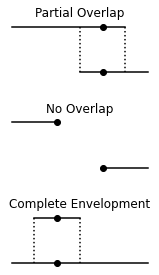

In [17]:
fig, ax = plt.subplots(3, 1)

fig.tight_layout(h_pad=2)

ax[0].plot([0, 2.5], [1, 1], color='k')
ax[0].plot([1.5, 3], [0, 0], color='k')
ax[0].plot([2.5, 2.5], [1, 0], ':', color='k')
ax[0].plot([1.5, 1.5], [1, 0], ':', color='k')
ax[0].plot(2, 1, 'o', color='k')
ax[0].plot(2, 0, 'o', color='k')
ax[0].set_ylim([-.1, 1.1])
ax[0].set_xlim([-.1, 3.1])
ax[0].set_aspect('equal', adjustable='box')
ax[0].axis('off')
ax[0].set_title('Partial Overlap')

ax[1].plot([0, 1], [1, 1], color='k')
ax[1].plot([2, 3], [0, 0], color='k')
#ax[1].plot([1, 1], [1, 0], ':', color='k')
#ax[1].plot([2, 2], [1, 0], ':', color='k')
ax[1].plot(1, 1, 'o', color='k')
ax[1].plot(2, 0, 'o', color='k')
ax[1].set_ylim([-.1, 1.1])
ax[1].set_xlim([-.1, 3.1])
ax[1].set_aspect('equal', adjustable='box')
ax[1].axis('off')
ax[1].set_title('No Overlap')

ax[2].plot([.5, 1.5], [1, 1], color='k')
ax[2].plot([0, 3], [0, 0], color='k')
ax[2].plot([.5, .5], [1, 0], ':', color='k')
ax[2].plot([1.5, 1.5], [1, 0], ':', color='k')
ax[2].plot(1, 1, 'o', color='k')
ax[2].plot(1, 0, 'o', color='k')
ax[2].set_ylim([-.1, 1.1])
ax[2].set_xlim([-.1, 3.1])
ax[2].set_aspect('equal', adjustable='box')
ax[2].axis('off')
ax[2].set_title('Complete Envelopment')

plt.show()

Consequently, the calculation for when the segments are parallel is quite simple:

In [18]:
# Returns the midpoint of the set of points on the capsule's segment whose
# smallest distance to the other capsule's segment is minimal
def contact_points_parallel(capsule_a, capsule_b):
    contact_a = .5 * (closest_on_segment(capsule_a.segment, capsule_b.segment[0]) \
                      + closest_on_segment(capsule_a.segment, capsule_b.segment[1]))
    contact_b = .5 * (closest_on_segment(capsule_b.segment, capsule_a.segment[0]) \
                      + closest_on_segment(capsule_b.segment, capsule_a.segment[1]))
    return contact_a, contact_b

The final implementation then is to try to use the non-parallel method. If it throws a ValueError, then it must be the case that the segments are parallel, in which case we use that method instead. We then check that the distance between the contact points (whose distance from eachother is the minimum of the distance between the between the segments) is less than the sum of the radii. If it is less, that there must be overlap between the two segments. If not, then there is no overlap, and we return None to signify this fact.

In [19]:
# If the capsules overlap, return the points on each capsule's central segment
# closest to the other capsule's central segment.
# Otherwise, return None
def contact_points(capsule_a, capsule_b):
    try:
        contact_a, contact_b = contact_points_not_parallel(capsule_a, capsule_b)
    except ValueError:
        contact_a, contact_b = contact_points_parallel(capsule_a, capsule_b)
    
    if distance_squared(contact_a, contact_b) < (contact_a.radius + contact_b.radius)**2:
        return contact_a, contact_b
    return None